# Tutorial - build LinearSVC model with sklearn

This tutorial demonstrates how to use the Sci-kit Learn (sklearn) package to build linearSVC model, rank features, and use the model for prediction. We will be using the Kaggle sentiment data again.

Note that sklearn actually provides two SVM algorithms: SVC and LinearSVC. 

The SVC module allows for choosing nonlinear kernels, and it uses one-vs-one strategy for multi-class classification.

The LinearSVC module uses the linear kernel, and it uses one-vs-all strategy for multi-class classification, so linearSVC is generally faster than SVC. Since linear kernel works better for text classification in general, this tutorial demonstrates how to use LinearSVC for text classification.

The data from the Kaggle Sentiment Analysis on Movie Review Competition are used in this tutorial. Check out the details of the data and the competition on Kaggle. https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

# Step 1: Read in data

In [55]:
# this step is the same as the NB script

# read in the training data
# the data set includes four columns: PhraseId, SentenceId, Phrase, Sentiment
# In this data set a sentence is further split into phrases 
# in order to build a sentiment classification model
# that can not only predict sentiment of sentences but also shorter phrases

# A data example:
# PhraseId SentenceId Phrase Sentiment
# 1 1 A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .1

# the Phrase column includes the training examples
# the Sentiment column includes the training labels
# "0" for very negative
# "1" for negative
# "2" for neutral
# "3" for positive
# "4" for very positive


import pandas as p
import numpy as np

train=p.read_csv("train.tsv", delimiter='\t')
y=train['Sentiment'].values
X=train['Phrase'].values

In [56]:
# borrowed from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# made a few modifications

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Step 2: Split train/test data for hold-out test

In [57]:
# this step is the same as the NB script

# check the sklearn documentation for train_test_split
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# "test_size" : float, int, None, optional
# If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. 
# If int, represents the absolute number of test samples. 
# If None, the value is set to the complement of the train size. 
# By default, the value is set to 0.25. The default will change in version 0.21. It will remain 0.25 only if train_size is unspecified, otherwise it will complement the specified train_size.    

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0])
print(y_train[0])
print(X_test[0])
print(y_test[0])

(93636,) (93636,) (62424,) (62424,)
almost in a class with that of Wilde
3
escape movie
2


Sample output from the code above:

(93636,) (93636,) (62424,) (62424,)
almost in a class with that of Wilde
3
escape movie
2

# Step 2.1 Data Checking

In [58]:
# this step is the same as the NB script

# Check how many training examples in each category
# this is important to see whether the data set is balanced or skewed

training_labels = set(y_train)
print(training_labels)
from scipy.stats import itemfreq
#training_category_dist = itemfreq(y_train) # deprecated
training_category_dist = np.unique(y_train, return_counts=True)
print(training_category_dist)

{0, 1, 2, 3, 4}
(array([0, 1, 2, 3, 4], dtype=int64), array([ 4141, 16449, 47718, 19859,  5469], dtype=int64))


The sample output shows that the data set is skewed with 47718/93636=51% "neutral" examples. All other categories are smaller.

{0, 1, 2, 3, 4}
[[    0  4141]
 [    1 16449]
 [    2 47718]
 [    3 19859]
 [    4  5469]]

# Step 3: Vectorization

In [59]:
# this step is the same as the NB script

# sklearn contains two vectorizers

# CountVectorizer can give you Boolean or TF vectors
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# TfidfVectorizer can give you TF or TFIDF vectors
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Read the sklearn documentation to understand all vectorization options

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# several commonly used vectorizer setting

#  unigram boolean vectorizer, set minimum document frequency to 5
unigram_bool_vectorizer = CountVectorizer(encoding='latin-1', binary=True, min_df=5, stop_words='english')

#  unigram term frequency vectorizer, set minimum document frequency to 5
unigram_count_vectorizer = CountVectorizer(encoding='latin-1', binary=False, min_df=5, stop_words='english')

#  unigram and bigram term frequency vectorizer, set minimum document frequency to 5
gram12_count_vectorizer = CountVectorizer(encoding='latin-1', ngram_range=(1,2), min_df=5, stop_words='english')

#  unigram tfidf vectorizer, set minimum document frequency to 5
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, stop_words='english')


## Step 3.1: Vectorize the training data

In [60]:
# this step is the same as the NB script

# The vectorizer can do "fit" and "transform"
# fit is a process to collect unique tokens into the vocabulary
# transform is a process to convert each document to vector based on the vocabulary
# These two processes can be done together using fit_transform(), or used individually: fit() or transform()

# fit vocabulary in training documents and transform the training documents into vectors
X_train_vec = unigram_count_vectorizer.fit_transform(X_train)

# check the content of a document vector
print(X_train_vec.shape)
print(X_train_vec[0].toarray())

# check the size of the constructed vocabulary
print(len(unigram_count_vectorizer.vocabulary_))

# print out the first 10 items in the vocabulary
print(list(unigram_count_vectorizer.vocabulary_.items())[:10])

# check word index in vocabulary
print(unigram_count_vectorizer.vocabulary_.get('imaginative'))

(93636, 11967)
[[0 0 0 ... 0 0 0]]
11967
[('class', 1858), ('wilde', 11742), ('derring', 2802), ('chilling', 1764), ('affecting', 313), ('meanspirited', 6557), ('personal', 7662), ('low', 6296), ('involved', 5602), ('worth', 11868)]
5224


Sample output:

(93636, 11967)
[[0 0 0 ..., 0 0 0]]
11967
[('imaginative', 5224), ('tom', 10809), ('smiling', 9708), ('easy', 3310), ('diversity', 3060), ('impossibly', 5279), ('buy', 1458), ('sentiments', 9305), ('households', 5095), ('deteriorates', 2843)]
5224

## Step 3.2: Vectorize the test data

In [61]:
# this step is the same as the NB script

# use the vocabulary constructed from the training data to vectorize the test data. 
# Therefore, use "transform" only, not "fit_transform", 
# otherwise "fit" would generate a new vocabulary from the test data

X_test_vec = unigram_count_vectorizer.transform(X_test)

# print out #examples and #features in the test set
print(X_test_vec.shape)

(62424, 11967)


Sample output:

(62424, 14324)

# Step 4: Train a LinearSVC classifier

In [62]:
# import the LinearSVC module
from sklearn.svm import LinearSVC

# initialize the LinearSVC model
svm_clf = LinearSVC(C=1)

# use the training data to train the model
svm_clf.fit(X_train_vec,y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Step 4.1 Interpret a trained LinearSVC model

In [63]:
## interpreting LinearSVC models
## http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

## LinearSVC uses a one-vs-all strategy to extend the binary SVM classifier to multi-class problems
## for the Kaggle sentiment classification problem, there are five categories 0,1,2,3,4 with 0 as very negative and 4 very positive
## LinearSVC builds five binary classifier, "very negative vs. others", "negative vs. others", "neutral vs. others", "positive vs. others", "very positive vs. others", 
## and then pick the most confident prediction as the final prediction.

## Linear SVC also ranks all features based on their contribution to distinguish the two concepts in each binary classifier
## For category "0" (very negative), get all features and their weights and sort them in increasing order
feature_ranks = sorted(zip(svm_clf.coef_[0], unigram_count_vectorizer.get_feature_names()))

## get the 10 features that are best indicators of very negative sentiment (they are at the bottom of the ranked list)
very_negative_10 = feature_ranks[-10:]
print("Very negative words")
for i in range(0, len(very_negative_10)):
    print(very_negative_10[i])
print()

## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
not_very_negative_10 = feature_ranks[:10]
print("not very negative words")
for i in range(0, len(not_very_negative_10)):
    print(not_very_negative_10[i])
print()


Very negative words
(1.621609985352805, 'cesspool')
(1.6484880658248473, 'disappointment')
(1.6592494717573891, 'pompous')
(1.6683696653344278, 'stinks')
(1.692774000848491, 'distasteful')
(1.6955905001314568, 'unwatchable')
(1.7526396170116, 'unbearable')
(1.7873566739084732, 'stinker')
(1.8228706381828546, 'disgusting')
(1.8233056841528026, 'worthless')

not very negative words
(-1.8329269295874608, 'hawke')
(-1.737280674234054, 'giddy')
(-1.6832953986723913, 'collar')
(-1.5847292703061437, 'swimfan')
(-1.5720764984867097, 'blue')
(-1.4801111844320054, 'dogtown')
(-1.4138360752647219, 'clamoring')
(-1.4093532523263224, 'joan')
(-1.3918160743119738, 'victim')
(-1.340000001594639, 'compulsively')



Sample output:

Very negative words
(1.5635285973159958, 'stunning')
(1.6005795078256047, 'astonish')
(1.610812924790558, 'refreshes')
(1.6148905161082145, 'flawless')
(1.6474647033330083, 'phenomenal')
(1.6506425169734038, 'masterful')
(1.67761558779458, 'masterfully')
(1.8781421016763864, 'glorious')
(1.9801881772566481, 'miraculous')
(2.0143251933052397, 'perfection')

not very negative words
(-2.3147454187985117, 'sacrifices')
(-1.8650987318574794, 'maintained')
(-1.8305667747223913, 'placed')
(-1.7974037295239631, 'argue')
(-1.6800998534753624, '19')
(-1.6684863939524339, 'homage')
(-1.6179084517399509, 'failure')
(-1.6088792786048403, 'breezy')
(-1.6059138072144292, 'bore')
(-1.5466693614369267, 'clone')

# Exercise A

In [64]:
# write code similar to the above sample code 
# and print out the 10 most indicative words for the "very positive" category

# Your code starts here
feature_ranks = sorted(zip(svm_clf.coef_[4], unigram_count_vectorizer.get_feature_names()))

## get the 10 features that are best indicators of very negative sentiment (they are at the bottom of the ranked list)
very_positive_10 = feature_ranks[-10:]
print("Very negative words")
for i in range(0, len(very_positive_10)):
    print(very_positive_10[i])
print()

## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
not_very_positive_10 = feature_ranks[:10]
print("not very negative words")
for i in range(0, len(not_very_positive_10)):
    print(not_very_positive_10[i])
print()
    
# Your code ends here

Very negative words
(1.5635285466417368, 'stunning')
(1.6005795191135457, 'astonish')
(1.6108128738715075, 'refreshes')
(1.6148905011936687, 'flawless')
(1.6474647027841378, 'phenomenal')
(1.6506425511356368, 'masterful')
(1.6776155702639488, 'masterfully')
(1.8781421386965036, 'glorious')
(1.9801880394573577, 'miraculous')
(2.014325176917502, 'perfection')

not very negative words
(-2.3147453292661933, 'sacrifices')
(-1.8650986140698191, 'maintained')
(-1.8305665987426005, 'placed')
(-1.7974037122577395, 'argue')
(-1.680099831588046, '19')
(-1.6684863479733538, 'homage')
(-1.6179084095307994, 'failure')
(-1.6088792824068165, 'breezy')
(-1.605913772852916, 'bore')
(-1.5466692820818242, 'clone')



In [65]:
for i in very_positive_10:
    print(str(i[1])+','+str(i[0])) 
    
print()

for i in very_negative_10:
    print(str(i[1])+','+str(i[0])) 

stunning,1.5635285466417368
astonish,1.6005795191135457
refreshes,1.6108128738715075
flawless,1.6148905011936687
phenomenal,1.6474647027841378
masterful,1.6506425511356368
masterfully,1.6776155702639488
glorious,1.8781421386965036
miraculous,1.9801880394573577
perfection,2.014325176917502

cesspool,1.621609985352805
disappointment,1.6484880658248473
pompous,1.6592494717573891
stinks,1.6683696653344278
distasteful,1.692774000848491
unwatchable,1.6955905001314568
unbearable,1.7526396170116
stinker,1.7873566739084732
disgusting,1.8228706381828546
worthless,1.8233056841528026


Sample output

(1.5635285973159958, 'stunning')
(1.6005795078256047, 'astonish')
(1.610812924790558, 'refreshes')
(1.6148905161082145, 'flawless')
(1.6474647033330083, 'phenomenal')
(1.6506425169734038, 'masterful')
(1.67761558779458, 'masterfully')
(1.8781421016763864, 'glorious')
(1.9801881772566481, 'miraculous')
(2.0143251933052397, 'perfection')

# Step 5: Test the LinearSVC classifier

In [66]:
# test the classifier on the test data set, print accuracy score

svm_clf.score(X_test_vec,y_test)

0.6236864026656415

[[  918  1221   697    82    13]
 [  701  4080  5504   514    25]
 [  195  2106 27081  2310   172]
 [   34   396  6048  5533  1057]
 [    3    51   590  1772  1321]]

Confusion matrix, without normalization
[[  918  1221   697    82    13]
 [  701  4080  5504   514    25]
 [  195  2106 27081  2310   172]
 [   34   396  6048  5533  1057]
 [    3    51   590  1772  1321]]
              precision    recall  f1-score   support

           0       0.50      0.31      0.38      2931
           1       0.52      0.38      0.44     10824
           2       0.68      0.85      0.75     31864
           3       0.54      0.42      0.48     13068
           4       0.51      0.35      0.42      3737

   micro avg       0.62      0.62      0.62     62424
   macro avg       0.55      0.46      0.49     62424
weighted avg       0.60      0.62      0.60     62424



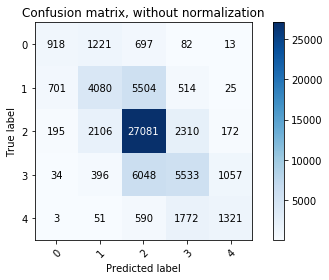

In [67]:
# print confusion matrix and classification report

from sklearn.metrics import confusion_matrix
y_pred = svm_clf.predict(X_test_vec)
cm=confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4])
print(cm)
print()
plot_confusion_matrix(y_test, y_pred)
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4']
print(classification_report(y_test, y_pred, target_names=target_names))

# Step 5.1 Interpret the prediction result

In [68]:
## get the confidence scores for all test examples from each of the five binary classifiers
svm_confidence_scores = svm_clf.decision_function(X_test_vec)
## get the confidence score for the first test example
print(svm_confidence_scores[0])

## sample output: array([-1.05306321, -0.62746206,  0.31074854, -0.89709483, -1.08343089]
## because the confidence score is the highest for category 2, 
## the prediction should be 2. 

## Confirm by printing out the actual prediction
print(y_test[0])

[-1.01718402 -0.5076003   0.22331224 -0.97514731 -1.24718852]
2


# Step 5.2 Error Analysis

In [69]:
# print out specific type of error for further analysis

# print out the very positive examples that are mistakenly predicted as negative
# according to the confusion matrix, there should be 53 such examples
# note if you use a different vectorizer option, your result might be different

err_cnt = 0
for i in range(0, len(y_test)):
    if(y_test[i]==4 and y_pred[i]==0):
        print(X_test[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

10 minutes into the film you 'll be white-knuckled and unable to look away .
the film is never dull
greatly impressed by the skill of the actors involved in the enterprise
errors: 3


# Exercise B

In [70]:
# write code to print out 
# the errors that very negative examples were mistakenly predicted as very positive?
# and the errors that very positive examples were mistakenly predicted as very negative?

# Try find lingustic patterns for these two types of errors
# Based on the above error analysis, what suggestions would you give to improve the current model?

# Your code starts here

err_cnt = 0
for i in range(0, len(y_test)):
    if(y_test[i]==0 and y_pred[i]==4):
        print(X_test[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

# Your code ends here

the film is not entirely successful
manages to bleed it almost completely dry of humor , verve and fun .
the spell they cast is n't the least bit mesmerizing
The Master of Disguise is funny -- not
being cast in action films when none of them are ever any good
But if the essence of magic is its make-believe promise of life that soars above the material realm , this is the opposite of a truly magical movie .
is not Edward Burns ' best film
bleed it almost completely dry of humor , verve and fun
Once the expectation of laughter has been quashed by whatever obscenity is at hand , even the funniest idea is n't funny .
manages to bleed it almost completely dry of humor , verve and fun
It may not be a great piece of filmmaking ,
Depicts the sorriest and most sordid of human behavior on the screen , then laughs at how clever it 's being .
a great movie it is not
errors: 13


# Step 6: write the prediction output to file

In [71]:
y_pred=svm_clf.predict(X_test_vec)
output = open('linearSVC_prediction_output.csv', 'w')
for x, value in enumerate(y_pred):
  output.write(str(value) + '\n') 
output.close()

# Step 6.1 Prepare submission to Kaggle sentiment classification competition

In [72]:
########## submit to Kaggle submission

# we are still using the model trained on 60% of the training data
# you can re-train the model on the entire data set 
#   and use the new model to predict the Kaggle test data
# below is sample code for using a trained model to predict Kaggle test data 
#    and format the prediction output for Kaggle submission

# read in the test data
kaggle_test=p.read_csv("test.tsv", delimiter='\t') 

# preserve the id column of the test examples
kaggle_ids=kaggle_test['PhraseId'].values

# read in the text content of the examples
kaggle_X_test=kaggle_test['Phrase'].values

# vectorize the test examples using the vocabulary fitted from the 60% training data
kaggle_X_test_vec=unigram_count_vectorizer.transform(kaggle_X_test)

# predict using the NB classifier that we built
kaggle_pred=svm_clf.fit(X_train_vec, y_train).predict(kaggle_X_test_vec)

# combine the test example ids with their predictions
kaggle_submission=zip(kaggle_ids, kaggle_pred)

# prepare output file
outf=open('kaggle/kaggle_submission_linearSVC.csv', 'w')

# write header
outf.write('PhraseId,Sentiment\n')

# write predictions with ids to the output file
for x, value in enumerate(kaggle_submission): outf.write(str(value[0]) + ',' + str(value[1]) + '\n')

# close the output file
outf.close()